In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
from datasets.kinetics import KineticsDataModule
from datasets.ucf import UCF101DataModule
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from datasets.video_transforms import PermuteVideoChannels, GaussianBlur, SelectFrames
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
datamodule = KineticsDataModule(
    data_dir="/vision/u/naagnes/video/train",
    num_workers=4,
    batch_size=1,
    frame_rate=30,
    image_size_student=224,
    num_frames_student=16,
    step_student=2,
    image_size_teacher=112,
    num_frames_teacher=64,
    step_teacher=4,
)
datamodule.setup("fit")
dataloader = datamodule.train_dataloader()

In [9]:
def view(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,20))
    for i, img in enumerate(imgs):
        img = img.detach().cpu().numpy().astype(np.uint8)
        axs[0, i].imshow(np.transpose(img, (1, 2, 0)))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def show(video, nrow=None):
    if nrow is not None:
        grid = make_grid(video, nrow=nrow)
    else:
        grid = make_grid(video)
    view(grid)

In [4]:
class VideoTransformTrain(object):
    def __init__(self, crop_size, num_frames, step, random_start):

        self.transform = transforms.Compose(
            [
                SelectFrames(num_frames, step, random_start),
                PermuteVideoChannels((0, 3, 1, 2)),  # T x H x W x C ---> T x C x H x W
                transforms.RandomResizedCrop(
                    crop_size, scale=(0.3, 1), ratio=(0.5, 2.0)
                ),
                # transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(1.0, 0.0, 0.0, 0.0)],  # not strengthened
                    p=0.0,
                ),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([GaussianBlur([0.1, 2.0], crop_size)], p=0.5),
                transforms.Normalize(
                    mean=torch.tensor([0.485, 0.456, 0.406]),
                    std=torch.tensor([0.229, 0.224, 0.225]),
                ),
                # PermuteVideoChannels((1, 0, 2, 3)),  # T x C x H x W ---> C x T x H x W
            ]
        )

    def __call__(self, x):
        # Input tensor should be of shape T x H x W x C.
        x = self.transform(x.float())
        return x

In [5]:
i = 0
xs, xt = [], []
for videos in dataloader:
    x_s, x_t = videos
    x_s = x_s.squeeze() # .permute((0, 3, 1, 2))
    x_t = x_t.squeeze() # .permute((0, 3, 1, 2))
    xs.append(x_s)
    xt.append(x_t)
    i += 1
    if i == 1:
        break

In [7]:
idx = 0

print(xs[idx].shape, xt[idx].shape)

torch.Size([3, 16, 224, 224]) torch.Size([3, 64, 112, 112])


torch.Size([16, 3, 224, 224]) tensor(0.) tensor(1.)


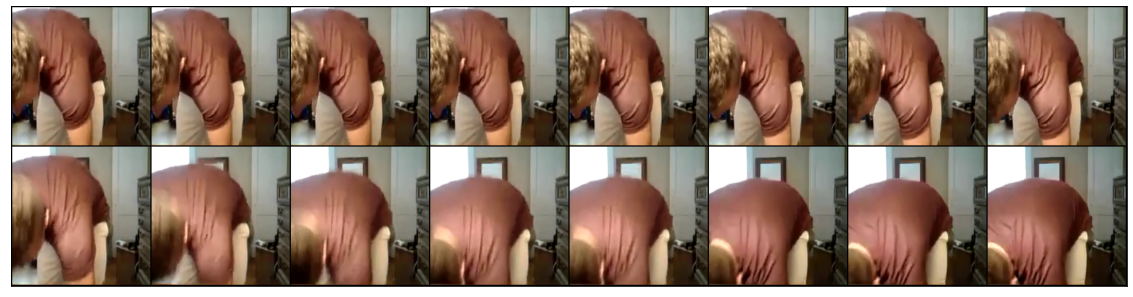

In [16]:
v = xs[idx].permute(1, 0, 2, 3)
v = (v - v.min()) / (v.max() - v.min())
print(v.shape, v.min(), v.max())
show(v*255)

torch.Size([64, 3, 112, 112]) tensor(0.) tensor(1.)


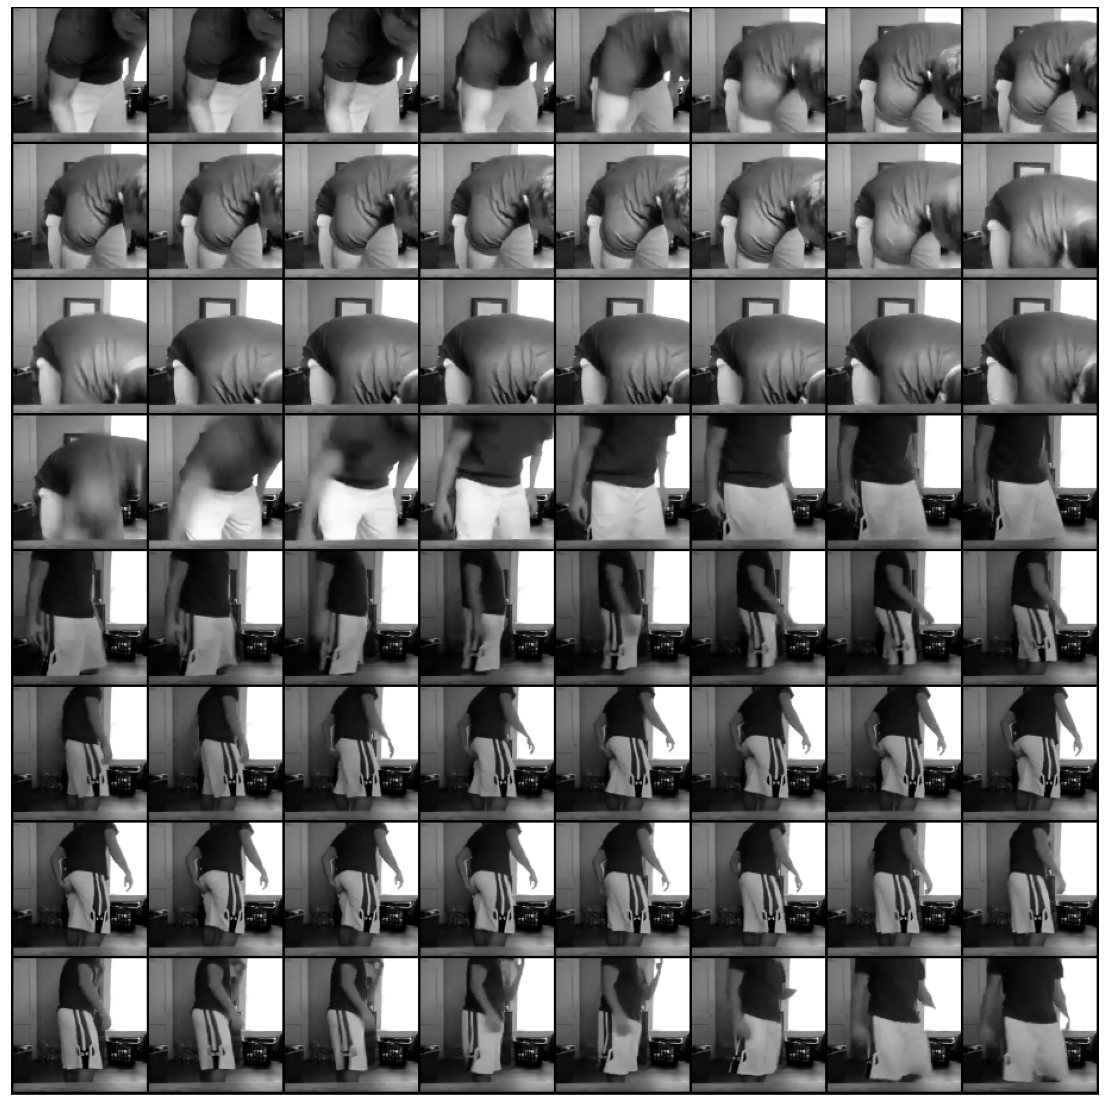

In [15]:
v = xt[idx].permute(1, 0, 2, 3)
v = (v - v.min()) / (v.max() - v.min())
print(v.shape, v.min(), v.max())
show(v*255)

In [ ]:
v = xt[idx]
print(v.shape)
show(v)

In [ ]:
transform = VideoTransformTrain(224, 16, 2, True)
print(xs[idx].shape, xs[idx].min(), xs[idx].max()) # T x H x W x C 
v = transform(xs[idx])
print(v.shape)
show(v)
# v.min(), v.max(), v.mean()

In [ ]:
transform = VideoTransformTrain(112, 64, 4, False)
v = transform(xt[idx])
print(v.shape)
show(v)

# UCF101 Dataset

In [6]:
datamodule = UCF101DataModule(
    data_dir="/vision/group/UCF-101",
    annotation_path="/vision/group/ucf101/ucfTrainTestlist",
    data_fold=1,
    num_workers=8,
    batch_size=8,
    image_size=224,
    num_frames=32,
    frame_step=2,
)
datamodule.setup("fit")
dataloader = datamodule.predict_dataloader()

train len 10000
len test 10000


In [11]:
i = 0
xs, xt = [], []
for videos, labels in dataloader:
    print(videos.shape, labels.shape)
    i += 1
    if i == 1:
        break

torch.Size([8, 3, 32, 224, 224]) torch.Size([8])


torch.Size([3, 32, 224, 224]) tensor(-1.9450) tensor(2.4026) tensor(0.1984)
torch.Size([3, 32, 224, 224]) tensor(0.) tensor(255.) tensor(125.7143)


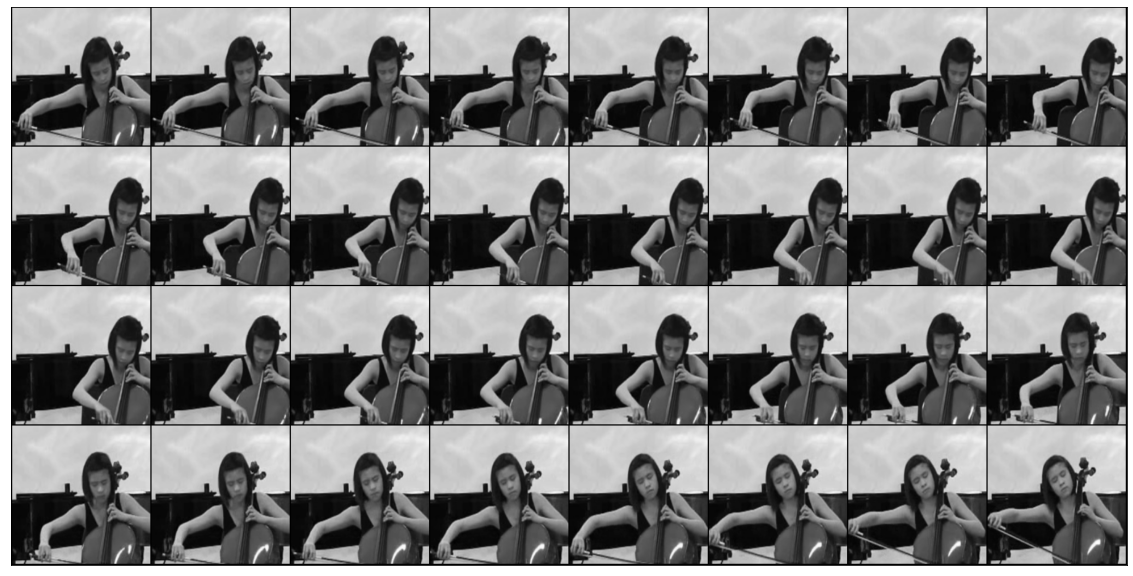

In [19]:
v = videos[1]
print(v.shape, v.min(), v.max(), v.mean())
v = (v - v.min()) / (v.max() - v.min()) * 255
print(v.shape, v.min(), v.max(), v.mean())
show(v.permute(1, 0, 2, 3))